In [6]:
import pandas as pd
pd.set_option('display.float_format', lambda x:f'{x:.1f}')

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
tf.random.set_seed(42) # Fix random seed for reproducability.

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [7]:
# Read the dataset
df = pd.read_excel('data\Water Consumption Data.xlsx')
df.head()

,Date,Water Consumption
0,2019-07-01,56293.2
1,2019-07-02,56549.4
2,2019-07-03,56870.4
3,2019-07-04,48988.8
4,2019-07-05,48006.4


Check for null values.

In [8]:
df.isna().sum()

Date                 0
Water Consumption    0
dtype: int64

Convert the date to the index of the data and plot the Water consumption feature.

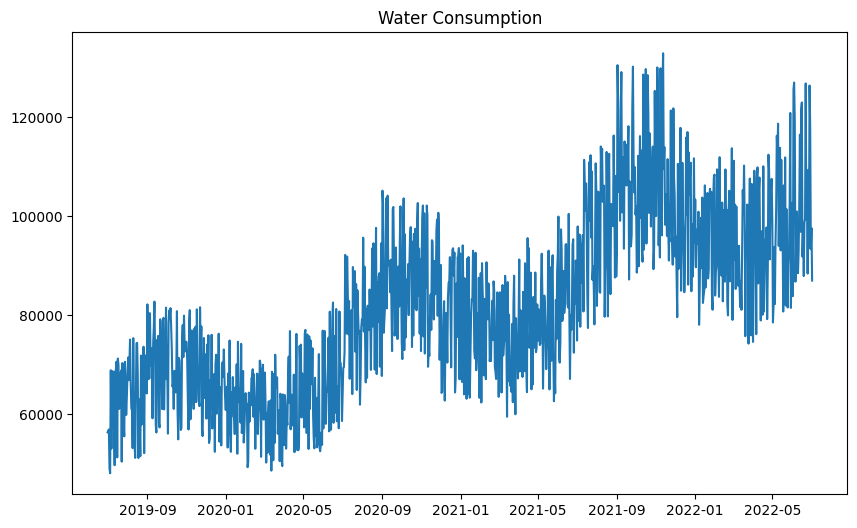

In [9]:
# Convert date to date time and insure it's the index of the dataframe
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(df['Water Consumption'])
plt.title('Water Consumption')
plt.show()

Split the dataset.

In [10]:
# Convert the dataset into numpy array
data = np.array(df)

In [11]:
# Scale the dataset
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

In [12]:
train_size = int(len(df) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

In [13]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

In [14]:
sequence_length =  60
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

In [15]:
# Reshape inputs to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


# 3. Model Training.

In [16]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(sequence_length, 1)),
    Dropout(0.2),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(128, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 60, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 60, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [17]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
11/11 [==============================] - 24s 375ms/step - loss: 0.0338 - val_loss: 0.0243
Epoch 2/10
11/11 [==============================] - 1s 69ms/step - loss: 0.0153 - val_loss: 0.0465
Epoch 3/10
11/11 [==============================] - 1s 70ms/step - loss: 0.0131 - val_loss: 0.0344
Epoch 4/10
11/11 [==============================] - 1s 70ms/step - loss: 0.0128 - val_loss: 0.0220
Epoch 5/10
11/11 [==============================] - 1s 67ms/step - loss: 0.0123 - val_loss: 0.0238
Epoch 6/10
11/11 [==============================] - 1s 73ms/step - loss: 0.0123 - val_loss: 0.0249
Epoch 7/10
11/11 [==============================] - 1s 66ms/step - loss: 0.0131 - val_loss: 0.0245
Epoch 8/10
11/11 [==============================] - 1s 61ms/step - loss: 0.0123 - val_loss: 0.0284
Epoch 9/10
11/11 [==============================] - 1s 74ms/step - loss: 0.0127 - val_loss: 0.0238
Epoch 10/10
11/11 [==============================] - 1s 66ms/step - loss: 0.0131 - val_loss: 0.0204


# 4. Evaluation.

In [18]:
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')

5/5 [==============================] - 0s 25ms/step - loss: 0.0203
Test Loss: 0.0203


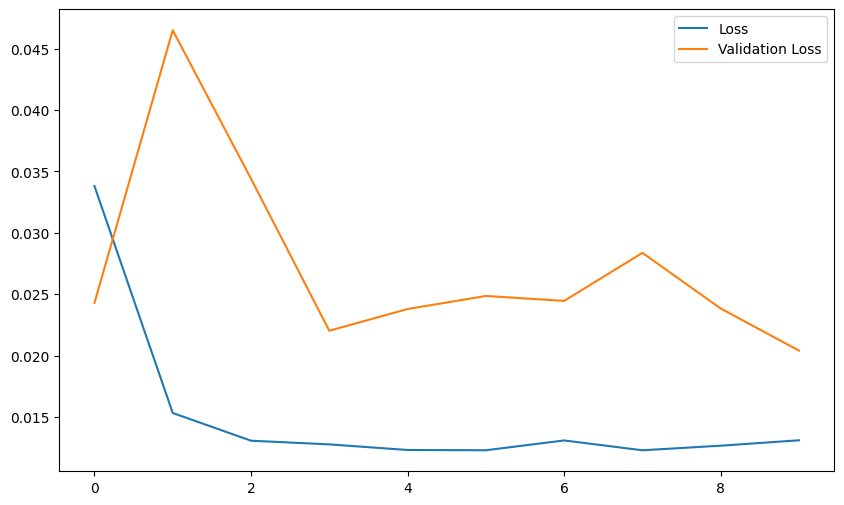

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Validation Loss'])
plt.show()

**Make predictions on the test set**


In [20]:
# Make predictions
predictions = model.predict(X_test)

# Inverse scale the predictions
predicted_values = scaler.inverse_transform(predictions)
actual_values = scaler.inverse_transform(y_test)

# Clip negative values to zero
predicted_values = np.clip(predicted_values, a_min=0, a_max=None)

5/5 [==============================] - 2s 27ms/step


In [21]:
# Compare predictions with actual values
comparison = pd.DataFrame({
    'Actual': actual_values[:, 0],
    'Predicted': predicted_values[:, 0],
})

comparison.head(20)

,Actual,Predicted
0,105516.7,94975.0
1,101798.7,95296.0
2,104904.7,95697.0
3,84155.5,96184.8
4,81062.9,96551.7
5,103272.8,96676.0
6,107877.0,96736.1
7,108387.9,96868.4
8,83938.0,97132.6
9,88547.6,97310.7


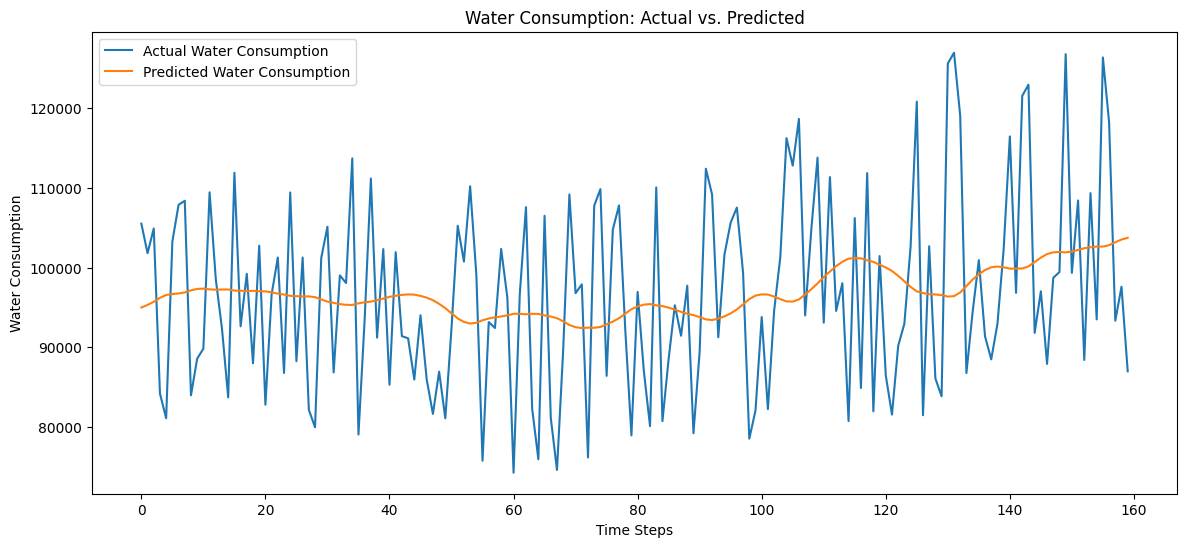

In [22]:
# Plot predictions vs. actual values for Water Consumption
plt.figure(figsize=(14, 6))
plt.plot(actual_values[:, 0], label='Actual Water Consumption')
plt.plot(predicted_values[:, 0], label='Predicted Water Consumption')
plt.title('Water Consumption: Actual vs. Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Water Consumption')
plt.legend()
plt.show()
